# Switchpoint analysis for coal mining disasters

The goal is to generate coal mining accident data set so that the true model is known.
Based on the generated observations, PyMC3 is used to approximate the true model and spot the switchpoint where the rate of accidents was changed due to policy changes.

This is an adapted version of [PyMC3 tutorial case](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters)

## Generation of observation dataset

The dataset contains count of accidents per annum, let's say from 1900 to 2000. Let's say that policymakers set new safety regulations for mining companies in 1950 which reduced accidents drastically.
So year 1950 will be our switchpoint in the rate of mining accidents. The switchpoint year is the hidden information which we are trying to figure out. When we know when the rate of accidents changed, we can further investigate what could have caused the change. In our simulated case, it'd be the regulations. The idea of the switchpoint detection is the same for all kinds of count data processes.

Because we are modeling the count of events in a fixed time interval (accident count per year), we are dealing with Poisson distributed data where Poisson parameter $\lambda$ changes after year 1950 so we have
two values for $\lambda$

$$
D_t \sim Pois(r_t), r_t =
\begin{cases}
e \text{ if } t \le s \\
l \text{ if } t \gt s
\end{cases}
$$

$$
\text{Prior distributions for parameters} \\
s \sim Unif(t_l, t_h) \\
e \sim Exp(1) \\
l \sim Exp(1)
$$

Let's generate data with true parameters $e$ and $l$

In [17]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from matplotlib import pyplot as plt
import arviz as az

In [18]:
tl = 1900
th = 2000
real_switchpoint = 1950

e = 3.0 # $lambda before year 1950
l = 1.0	# $lambda after year 1950

In [19]:
def generate_dataset(e, l, first_year, last_year, switchpoint):
	years = np.arange(first_year, last_year)
	counts = np.concatenate((np.random.poisson(e, switchpoint - first_year),
							np.random.poisson(l, last_year - switchpoint)))

	return pd.DataFrame(data=list(zip(years, counts)),
						columns=['year', 'accident_count'])

In [20]:
data = generate_dataset(e, l, tl, th, real_switchpoint)
data

,year,accident_count
0,1900,4
1,1901,4
2,1902,3
3,1903,5
4,1904,2
...,...,...
95,1995,0
96,1996,0
97,1997,1
98,1998,1


## Data exploration

<AxesSubplot:xlabel='year', ylabel='accident_count'>

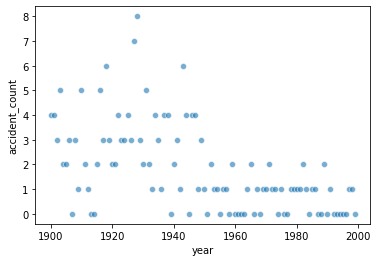

In [21]:
sns.lineplot(x=data['year'], y=data['accident_count'], data=data, marker='o', linestyle='', alpha=0.6)

<BarContainer object of 100 artists>

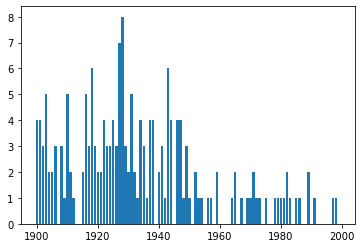

In [22]:
plt.bar(data['year'], data['accident_count'])

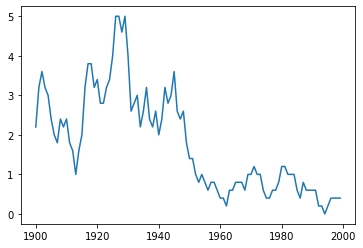

In [23]:
N = 5
five_year_moving_average = np.convolve(data['accident_count'], np.ones(N)/N, mode='same')

plt.plot(data['year'], five_year_moving_average)

The 5-year moving average already shows that there's a significant change around 1950. Because the change is so significant, the change can easily be detected from visualisations.
Subtle changes usually require more analytical operations to be spotted.

## MCMC inference
Let's try to infer true rates $e$ and $l$ with more precise switchpoint year

In [24]:
with pm.Model() as model:
	# Priors for the rates
	# Exponential distribution was chosen because it's restricted to [0, infinity]
	# There cannot be negative accidents
	e = pm.Exponential('early_mean', 1.0)
	l = pm.Exponential('late_mean', 1.0)

	# Set test value to the starting year
	# It sets all the distributions to start from there and the sampling will also start from there
	# Use uniform as a prior to assign equal weight to each year
	switchpoint = pm.DiscreteUniform('switchpoint', tl, th)

	# How many accidents per yea
	# Wrap in deterministic variable so that we can see it in the posterior results
	rate = pm.Deterministic('rate', pm.math.switch(switchpoint >= data['year'], e, l))
	disasters = pm.Poisson('disasters', rate, observed=data['accident_count'])

	trace = pm.sample(10000)


<ipython-input-24-485702e037e0>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [late_mean, early_mean]
>Metropolis: [switchpoint]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 10 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
with model:
	inferred_data = az.from_pymc3(trace)

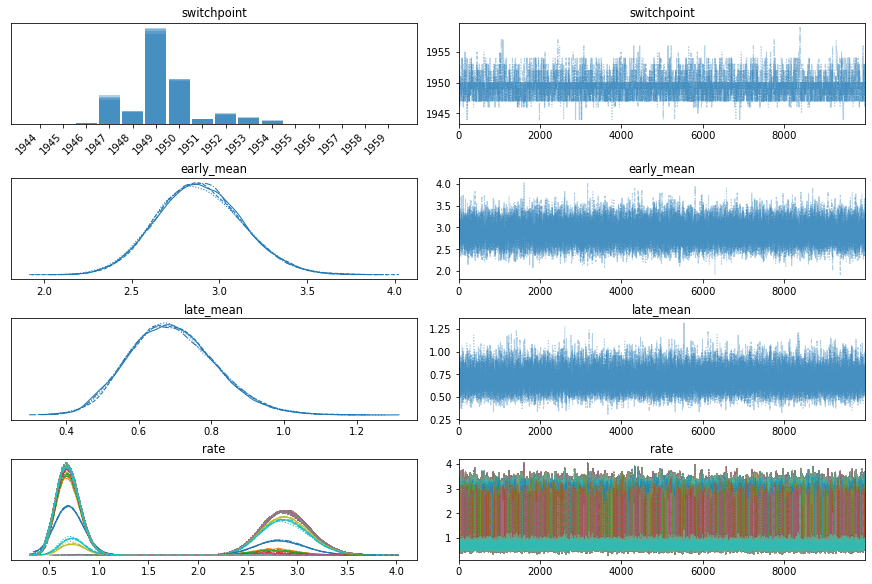

In [26]:
with model:
	axes_arr = az.plot_trace(trace)

for ax in axes_arr.flatten():
	if ax.get_title() == "switchpoint":
		labels = [label.get_text() for label in ax.get_xticklabels()]
		ax.set_xticklabels(ax.get_xticks(), rotation=45, ha="right")
		break

plt.draw()

In [27]:
with model:
    summary = az.summary(trace, round_to=2)
    display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
switchpoint,1949.28,1.53,1947.00,1952.00,0.03,0.02,4061.54,4741.77,1.0
early_mean,2.89,0.24,2.43,3.34,0.00,0.00,26863.75,25947.64,1.0
late_mean,0.69,0.12,0.48,0.92,0.00,0.00,28395.39,26709.43,1.0
rate[0],2.89,0.24,2.43,3.34,0.00,0.00,26863.75,25947.64,1.0
rate[1],2.89,0.24,2.43,3.34,0.00,0.00,26863.75,25947.64,1.0
...,...,...,...,...,...,...,...,...,...
rate[95],0.69,0.12,0.48,0.92,0.00,0.00,28395.39,26709.43,1.0
rate[96],0.69,0.12,0.48,0.92,0.00,0.00,28395.39,26709.43,1.0
rate[97],0.69,0.12,0.48,0.92,0.00,0.00,28395.39,26709.43,1.0
rate[98],0.69,0.12,0.48,0.92,0.00,0.00,28395.39,26709.43,1.0


array([<AxesSubplot:title={'center':'switchpoint'}>,
       <AxesSubplot:title={'center':'early_mean'}>,
       <AxesSubplot:title={'center':'late_mean'}>], dtype=object)

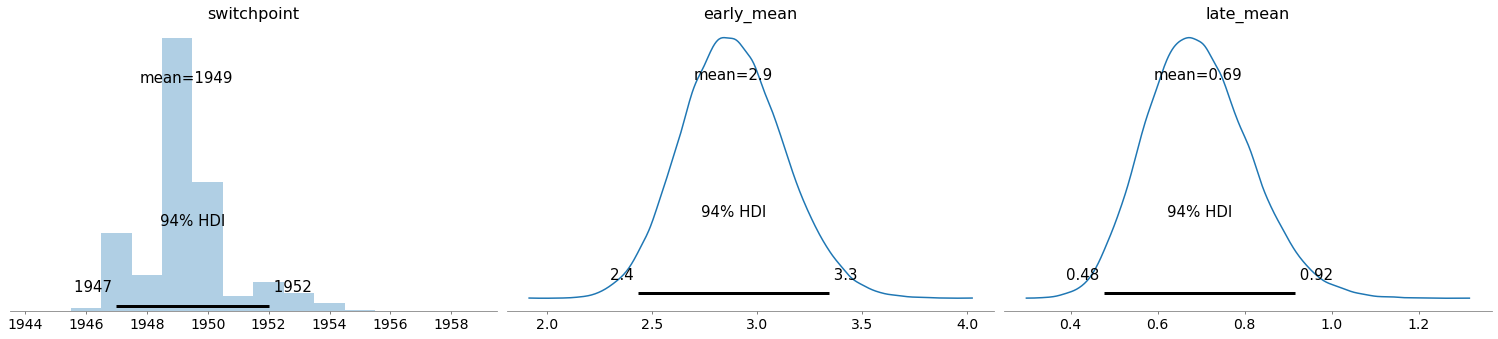

In [39]:
az.plot_posterior(trace, ['switchpoint', 'early_mean', 'late_mean'])

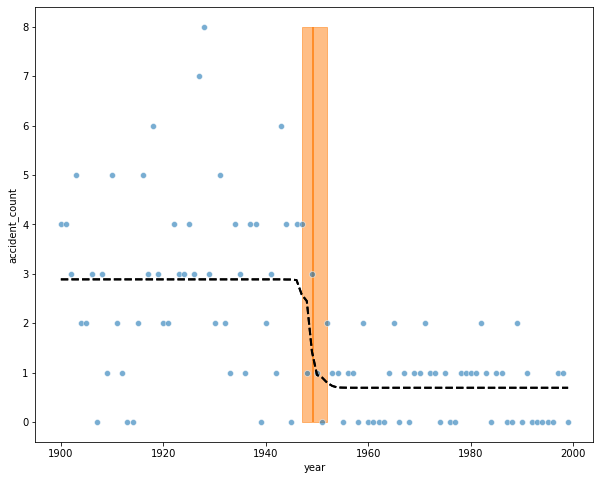

In [79]:
plt.figure(figsize=(10, 8))

sns.lineplot(x=data['year'], y=data['accident_count'], data=data, marker='o', linestyle='', alpha=0.6)

plt.vlines(trace["switchpoint"].mean(), data['accident_count'].min(), data['accident_count'].max(), color="C1")
average_disasters = np.zeros_like(data, dtype="float")

for i, year in enumerate(data['year']):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_mean"], trace["late_mean"]))
 
sp_hpd = az.hdi(trace["switchpoint"])
plt.fill_betweenx(
    y=[data['accident_count'].min(), data['accident_count'].max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(data['year'], average_disasters, "k--", lw=2)

## Convergence tests

/home/late/anaconda3/envs/datascience/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
<ipython-input-28-48211669b855>:6: DeprecationWarning: The function `energyplot` from PyMC3 is just an alias for `plot_energy` from ArviZ. Please switch to `pymc3.plot_energy` or `arviz.plot_energy`.
  pm.energyplot(trace, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))


Text(0.5, 1.0, 'BFMI = [1.00150625 0.93492231 1.00440537 0.96977376]\nGelman-Rubin = 1.0')

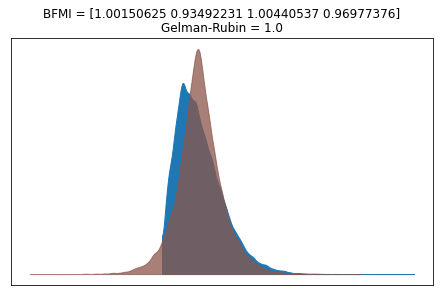

In [28]:
# BFMI & Gelman-Rubin
# Both BFMI and Gelman-Rubin should be close to 1.0 if posterior exploration has converged
bfmi = az.bfmi(trace)
max_gr = max(np.max(gr_stats) for gr_stats in summary['r_hat'])
pm.energyplot(trace, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr))

In [81]:
# display the total number and percentage of divergent
divergent = trace["diverging"]
print("Number of Divergent %d" % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size / len(trace) * 100
print("Percentage of Divergent %.1f" % divperc)

Number of Divergent 0
Percentage of Divergent 0.0


It seems the model converged without any issues.

## Non-existing switchpoint